In [11]:
#import libraries

import tensorflow as tf
import numpy as np
from keras.models import load_model
import pandas as pd
import matplotlib.pyplot as plt
import math as mt
from tensorflow import keras
from keras import layers
import os
import keras.backend as k
import logomaker as lm

2023-05-12 11:56:48.874603: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-05-12 11:56:48.935101: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-05-12 11:56:49.266582: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/dell3/anaconda3/envs/workenv/lib/
2023-05-12 11:56:49.266614: W tensorflow/compiler/xla/str

In [12]:
# Générer une séquence d'ADN à partir du modèle
modelgen = load_model('/home/florian/projet/generators/generatorRL.h5', compile=False)
seq_generated = modelgen.predict(tf.random.normal((1, 1)))
model_name='new_cut_2001_KC_G'
modelpredict = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)
seq_predicted = modelpredict.predict(seq_generated)
del modelgen, modelpredict

1/1 [==============================] - 0s 50ms/step


In [6]:
seq_generated,seq_predicted

(array([[[0.24988578, 0.24988578, 0.24988578, 0.25034267],
         [0.25146943, 0.24893247, 0.25066563, 0.24893247],
         [0.25      , 0.25      , 0.25      , 0.25      ],
         ...,
         [0.25025204, 0.2505054 , 0.2496213 , 0.2496213 ],
         [0.24972644, 0.24972644, 0.24972644, 0.2508207 ],
         [0.25180018, 0.24935949, 0.24948084, 0.24935949]]], dtype=float32),
 array([[2.843621e-07]], dtype=float32))

In [8]:

generator= tf.keras.models.Sequential([
        keras.Input(shape=(1)),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense((40000), activation="relu"),
        tf.keras.layers.Reshape((10000,4)),
        tf.keras.layers.Lambda(lambda x: tf.nn.softmax(x, axis=2))
        ])

class RL(keras.Model):
    def __init__(self, predictor, generator,requested_peak_height,requested_peak_loc):
        super(RL, self).__init__()
        self.predictor = predictor
        self.generator = generator
        self.requested_peak_height=requested_peak_height
        self.requested_peak_loc=requested_peak_loc

    def compile(self, g_optimizer, loss_fn):
        super(RL, self).compile()
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    # @tf.function
    # def maybe_changeLR(self, g_loss):
    #     a=self.g_optimizer.lr.read_value()
    #     print(a)
    #     if g_loss >= self.requested_peak_height/2:
    #         self.g_optimizer.lr.assign(1)
    #     else:
    #         self.g_optimizer.lr.assign(a*tf.math.exp(-0.1))

    #     print(a)

    def train_step(self,_):

        with tf.GradientTape() as tape:
            seq=self.generator(tf.random.normal((1, 1)))[:,self.requested_peak_loc-1000:self.requested_peak_loc+1001]
            predictions = self.predictor(seq)
            g_loss = self.loss_fn(self.requested_peak_height, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))
        # self.maybe_changeLR(g_loss)
 
        return {"g_loss": g_loss}

In [ ]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.5,patience=5, min_lr=0.001)

In [9]:
model_name='new_cut_2001_KC_G'
predictor = load_model('/home/florian/projet/models/'+ model_name +'/'+ model_name+ '.h5', compile=False)

rl = RL(predictor=predictor, generator=generator,requested_peak_height=0.8,requested_peak_loc=5000)

rl.compile(g_optimizer=keras.optimizers.Adam(learning_rate=1),
         loss_fn=keras.losses.MeanAbsoluteError(reduction=tf.keras.losses.Reduction.SUM))

history=rl.fit(tf.random.normal((1, 1)), epochs=50)#, callbacks=[reduce_lr])

Epoch 1/50


2023-05-05 15:48:12.756659: I tensorflow/compiler/xla/service/service.cc:173] XLA service 0x7f3f32ba2490 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-05-05 15:48:12.756674: I tensorflow/compiler/xla/service/service.cc:181]   StreamExecutor device (0): NVIDIA GeForce RTX 3090, Compute Capability 8.6
2023-05-05 15:48:12.765091: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-05-05 15:48:12.867569: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-05-05 15:48:12.892000: I tensorflow/compiler/jit/xla_compilation_cache.cc:477] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1/1 [==============================] - 1s 733ms/step - g_loss: 0.8000
Epoch 2/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 3/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 4/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 5/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 6/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 7/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 8/50
1/1 [==============================] - 0s 2ms/step - g_loss: 0.8000
Epoch 9/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 10/50
1/1 [==============================] - 0s 3ms/step - g_loss: 0.8000
Epoch 11/50
1/1 [==============================] - 0s 4ms/step - g_loss: 0.8000
Epoch 12/50
1/1 [==============================] - 0s 5ms/step - g_loss: 0.8000
Epoch 13/50
1/1 [==============================] - 0s 3ms/

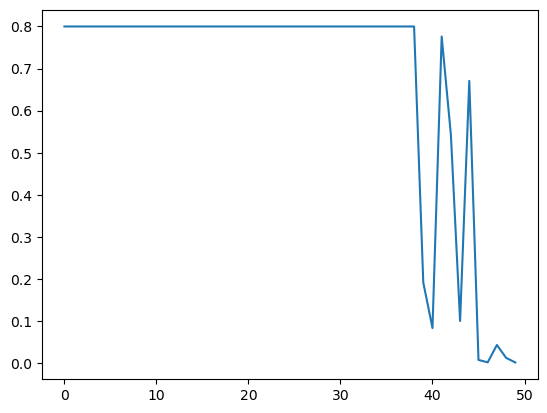

In [10]:
hist_df = pd.DataFrame(history.history) 
plt.plot(hist_df,label='loss')

In [49]:
seq1=rl.generator(tf.constant([0.1]))
seq2=rl.generator(tf.constant([0.9]))

In [12]:
def fast_pred(input,model):
    return model(tf.cast(input,tf.float32))

def fast_pred_seq(input,window_start,model,size=2001):
    X=[]
    for i in range(window_start,window_start+size):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return(X)

def fast_pred_whole_seq(input,model,size=2001):
    X=[]
    length=len(np.array(input[0]))
    for i in range(size//2,length-(size//2),10):
        X.append(np.array(fast_pred(input[:,i-(size//2):i+(size//2)+1],model))[0])
    return([0 for i in range(0,size//2,10)] + X +[0 for i in range(0,size//2,10)])

In [17]:
L=fast_pred_seq(seq,window_start=4000,model=predictor,size=2001)

In [360]:
Lfull=fast_pred_whole_seq(seq,model=predictor)

In [19]:
Lfull1=fast_pred_whole_seq(seq1,model=predictor)
Lfull2=fast_pred_whole_seq(seq2,model=predictor)

/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


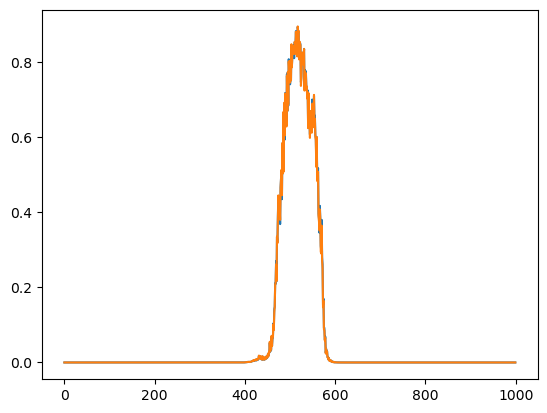

In [20]:
plt.plot(Lfull1)
plt.plot(Lfull2)

In [61]:
seq1,seq2

(<tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29096353, 0.23528711, 0.23528711, 0.23846225],
         [0.2284247 , 0.2465257 , 0.23974851, 0.2853011 ],
         [0.24886386, 0.24886386, 0.24886386, 0.25340843],
         ...,
         [0.24158771, 0.2538151 , 0.24158771, 0.2630095 ],
         [0.24486396, 0.27335063, 0.23215218, 0.24963328],
         [0.25757158, 0.26343003, 0.22679976, 0.25219864]]], dtype=float32)>,
 <tf.Tensor: shape=(1, 10000, 4), dtype=float32, numpy=
 array([[[0.29070714, 0.23643096, 0.23643096, 0.23643096],
         [0.23545791, 0.2535034 , 0.23562671, 0.27541193],
         [0.24857995, 0.24857995, 0.24857995, 0.2542601 ],
         ...,
         [0.24369319, 0.25565547, 0.24369319, 0.25695813],
         [0.24278596, 0.26873428, 0.23461801, 0.25386176],
         [0.2606971 , 0.26555744, 0.23001789, 0.24372756]]], dtype=float32)>)

In [9]:
start = 5000
stop = start + 50

In [64]:
# seq=np.array(seq)
# seq=seq.reshape(10000,4)
logo1=pd.DataFrame(np.array(seq1).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])
logo2=pd.DataFrame(np.array(seq2).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])

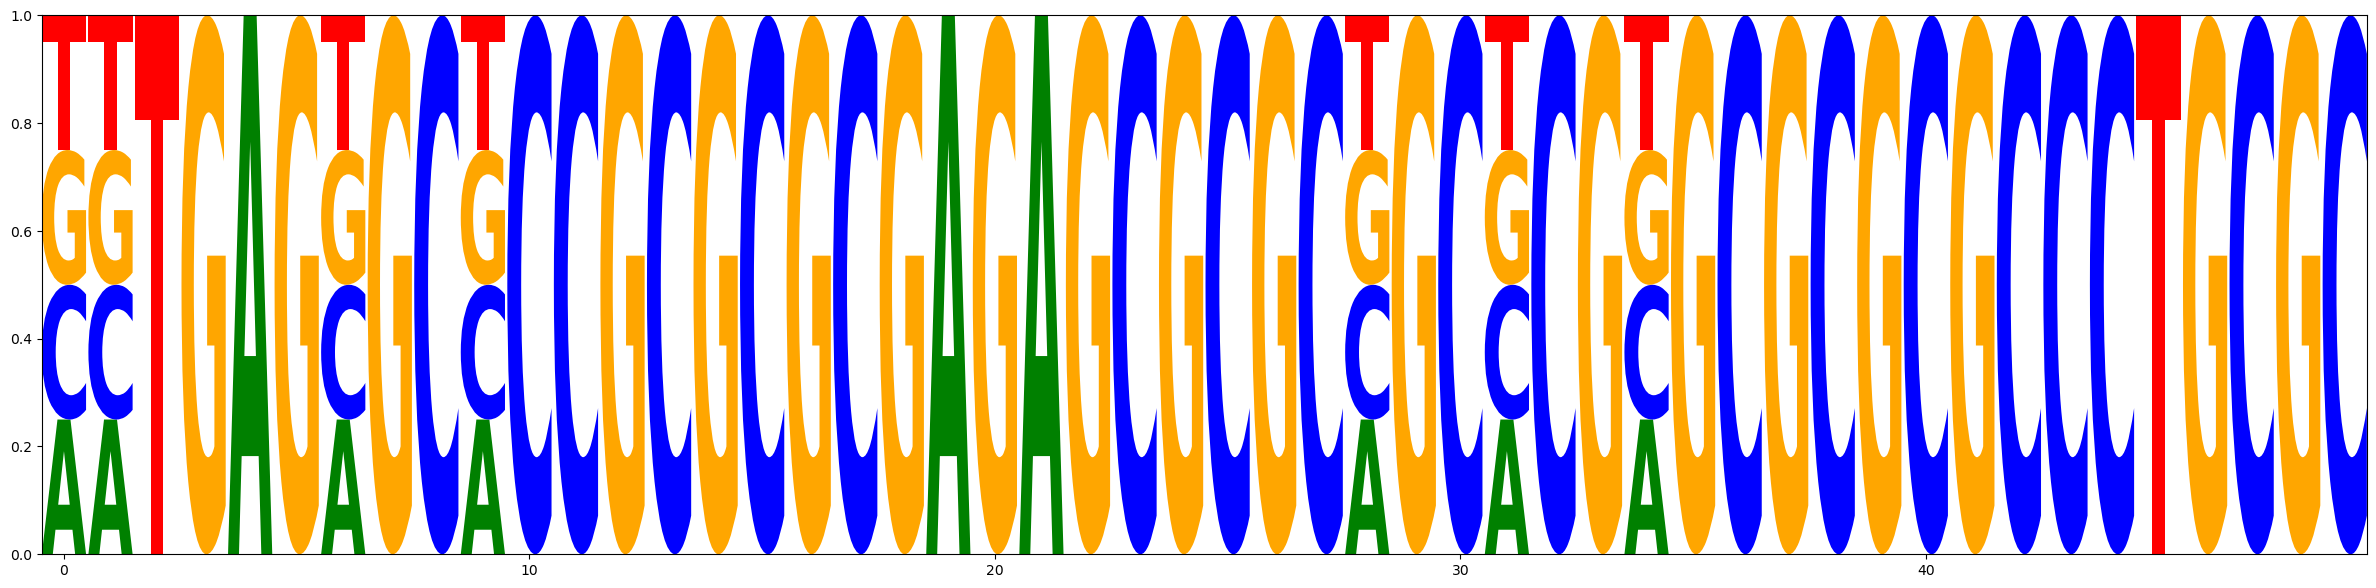

In [65]:
lm.Logo(logo1, figsize=(30, 7))

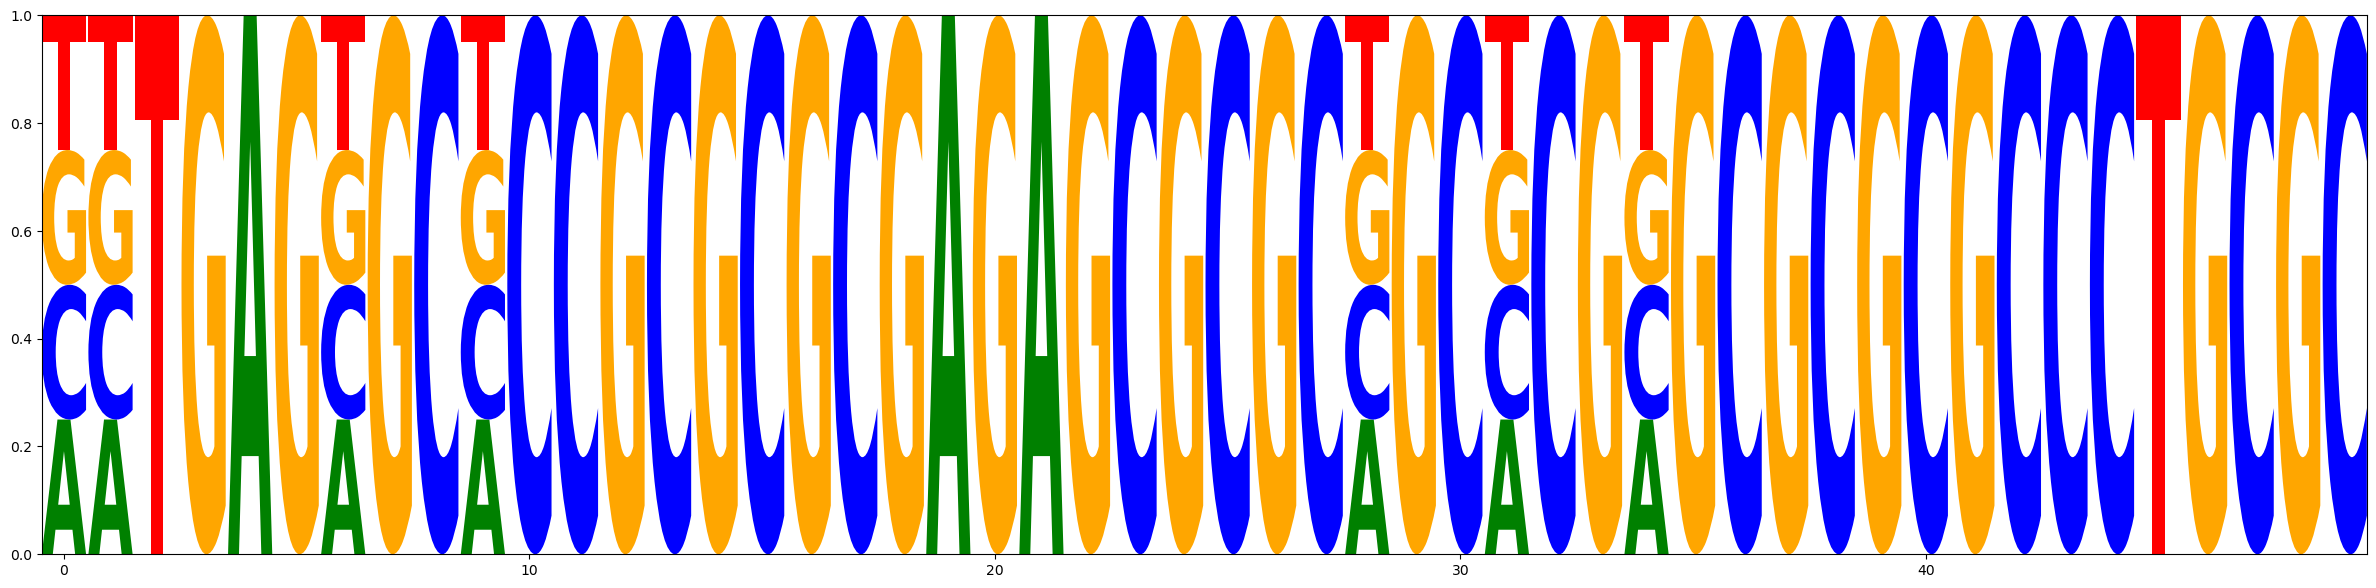

In [66]:
lm.Logo(logo2, figsize=(30, 7))

In [168]:
def seq_entropy(seq):
    X=[]
    for i in seq:
        s=0
        for p in i:
            s+=p*mt.log(p+k.epsilon())
        X.append(s)
    return X

In [169]:
E=seq_entropy(seq1[0])

Text(0.5, 1.0, 'zoom on 4000-6000')

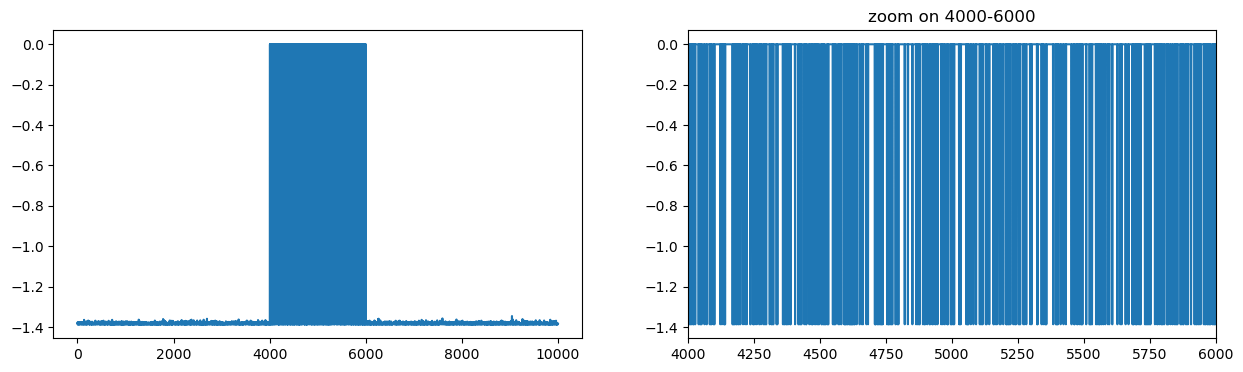

In [171]:
plt.figure(figsize=(15, 4))
plt.subplot(1,2,1)
plt.plot(E)
plt.subplot(1,2,2)
plt.plot(E)
plt.xlim(4000,6000)
plt.title('zoom on 4000-6000')
# plt.subplot(1,4,4)
# lm.Logo(logo1)

In [32]:
def undifined_rate(seq):
    c=0
    for i in seq:
        if 0.2<max(i)<0.3:
            c+=1
    return(c/len(seq))   

def GC_content(seq):
    c=0
    for i in seq:
        if i == "G":
            c+=1
        elif i == "C":
            c+1
    return (round(c/len(seq)*100,2))

def force_ohe(seq):
    for i in range(len(seq)):
        new=[0,0,0,0]
        print(seq[i])
        max=max(seq[i])
        if max==0.25:
            new[np.random.randint(0,3)]=1
        else:
            new[seq[i].index(max(seq[i]))]=1
        seq[i]=new
    return (seq)

In [33]:
seq=np.array(([0.1,0.1,0.8,0],[0.1,0.1,0.8,0],[0.1,0.1,0.8,0],[0.1,0.1,0.8,0],[0.1,0.1,0.8,0],[0.1,0.1,0.8,0],[0.1,0.1,0.8,0]))

In [37]:
[0.1,0.1,0.8,0].index(0.8)

2

In [56]:
force_ohe(seq)

[0.1 0.1 0.8 0. ]


AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [57]:
force_ohe(seq_generated[0])

NameError: name 'seq_generated' is not defined

In [19]:
model_name="latentdim10_CNN_40epochs"

In [18]:
modelgan = load_model('/home/florian/projet/generators/'+model_name+'.h5', compile=False)
seq_generated = modelgan.predict(tf.random.normal((1, 10)))

2023-05-12 11:58:16.943483: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:219] failed to create cublas handle: cublas error
2023-05-12 11:58:16.943500: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:221] Failure to initialize cublas may be due to OOM (cublas needs some free memory when you initialize it, and your deep-learning framework may have preallocated more than its fair share), or may be because this binary was not built with support for the GPU in your machine.
2023-05-12 11:58:16.943507: W tensorflow/core/framework/op_kernel.cc:1830] OP_REQUIRES failed at matmul_op_impl.h:622 : INTERNAL: Attempting to perform BLAS operation using StreamExecutor without BLAS support


InternalError: Graph execution error:

Detected at node 'sequential/dense_1/MatMul' defined at (most recent call last):
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/tornado/platform/asyncio.py", line 215, in start
      self.asyncio_loop.run_forever()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/asyncio/base_events.py", line 603, in run_forever
      self._run_once()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/asyncio/base_events.py", line 1906, in _run_once
      handle._run()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 2945, in run_cell
      result = self._run_cell(
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3000, in _run_cell
      return runner(coro)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3203, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3382, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/IPython/core/interactiveshell.py", line 3442, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_122391/196385365.py", line 2, in <module>
      seq_generated = modelgan.predict(tf.random.normal((1, 1)))
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 2350, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 2137, in predict_function
      return step_function(self, iterator)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 2123, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 2111, in run_step
      outputs = model.predict_step(data)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 2079, in predict_step
      return self(x, training=False)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/engine/base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "/home/dell3/anaconda3/envs/workenv/lib/python3.10/site-packages/keras/layers/core/dense.py", line 241, in call
      outputs = tf.matmul(a=inputs, b=self.kernel)
Node: 'sequential/dense_1/MatMul'
Attempting to perform BLAS operation using StreamExecutor without BLAS support
	 [[{{node sequential/dense_1/MatMul}}]] [Op:__inference_predict_function_1167]

In [8]:
seq_generated[0][start:stop]

array([[2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [1.8488919e-07, 1.8488919e-07, 1.8488919e-07, 9.9999940e-01],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [1.5809090e-07, 9.9999952e-01, 1.5809090e-07, 1.5809090e-07],
       [3.1189913e-07, 3.1189913e-07, 9.9999905e-01, 3.1189913e-07],
       [2.5000000e-01, 2.5000000e-01, 2.5000000e-01, 2.5000000e-01],
       [9.9999881e-01, 3.9277541e-07, 3.9277541e-07, 3.9277541e-07],
       [3.6249966e-07, 3.6249966e-07, 3.6249966e-07, 9.9999893e-01],
       [2.5000000e-01, 2.5000000e-

In [9]:
undifined_rate(seq_generated[0])

0.6675

In [10]:
start = 3000
stop = start + 100
logo=pd.DataFrame(np.array(seq_generated).reshape(10_000,4)[start:stop], columns=["A", "C", "G", "T"])

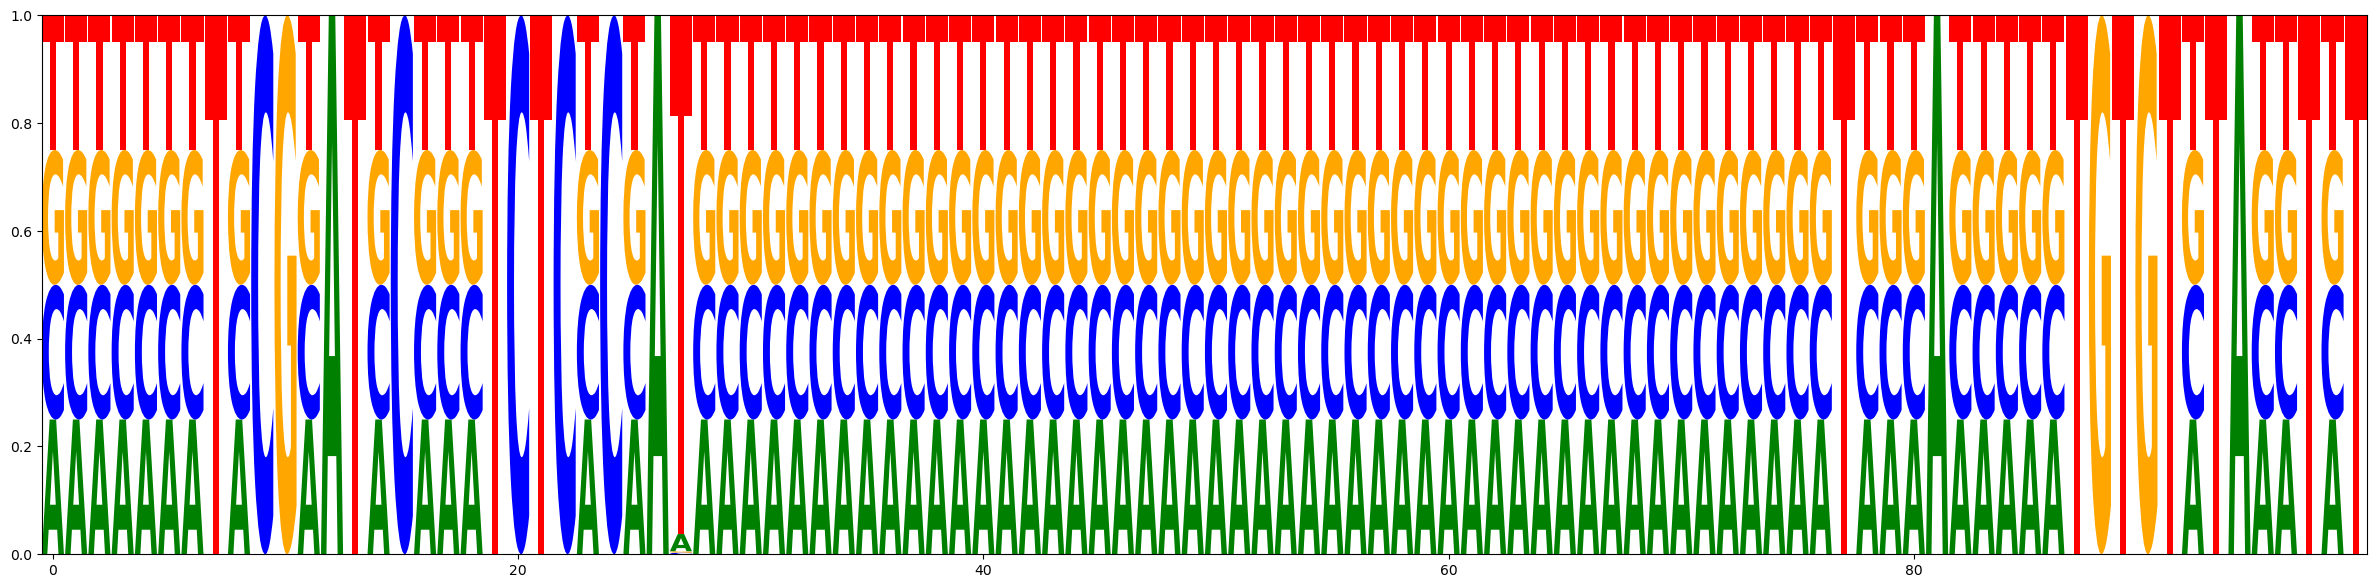

In [11]:
lm.Logo(logo, figsize=(30, 7))

In [12]:
df = pd.read_csv ('/home/florian/projet/generators/'+model_name+'history.csv')

Text(0.5, 1.0, 'loss values')

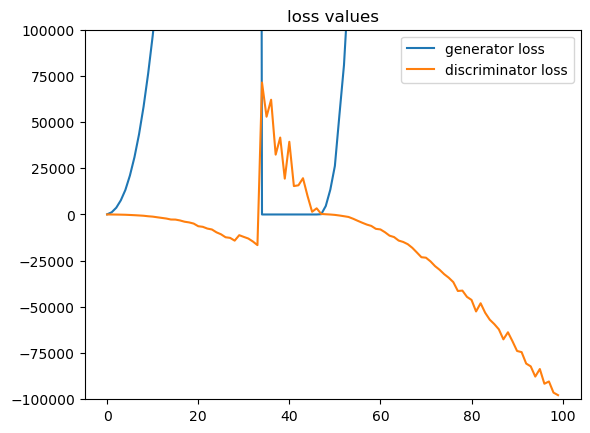

In [32]:
plt.plot(df['g_loss'],label='generator loss')
plt.plot(df['d_loss'],label="discriminator loss")
plt.legend()
plt.ylim(-100000,100000)
plt.title('loss values')

In [144]:
G_LOSS=[]
D_LOSS=[]
for i in range(len(df['d_loss'])):
    G_LOSS.append([float(v) for s in df['g_loss'][i][:-1].split('\n') for v in s[1:].split()][-1])
    D_LOSS.append([float(v) for s in df['d_loss'][i][:-1].split('\n') for v in s[1:].split()][-1])

IndexError: invalid index to scalar variable.

In [ ]:
plt.plot(G_LOSS,label='generator loss')
plt.plot(D_LOSS,label="discriminator loss")
plt.legend()
plt.title('loss values')

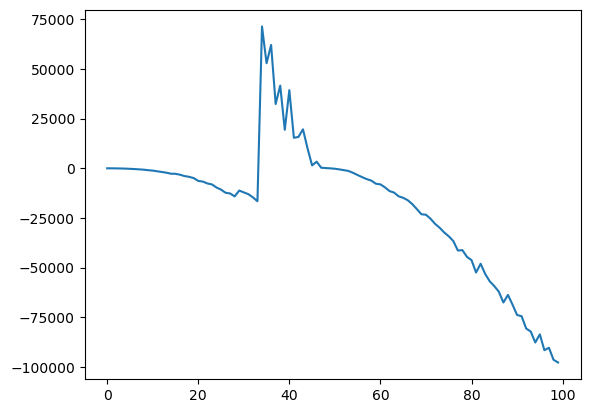

In [15]:
plt.plot(df['d_loss'])

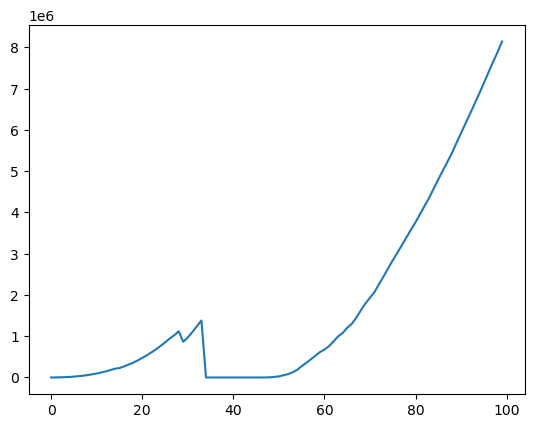

In [21]:
plt.plot(df['g_loss'])

In [22]:
1e6

1000000.0